In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
def MSE(y, Y):
    return ((Y-y)*(Y-y)).sum()/len(Y)

In [3]:
def sigmo(x):
    return 1/(1+np.exp(-x))

In [4]:
def sigmo_der(x):
    s = sigmo(np.array(x))
    return s*(1-s)

In [5]:
def read(path):
    D = pd.read_csv(path)
    x = np.array(D.x)
    y = np.array(D.y)
    return x,y

In [6]:
class NeuralNetwork(object):
    def __init__(self,layers,fun=sigmo,fun_der=sigmo_der):
        outs = layers[1:]
        ins = layers[:-1]
        self.w = [np.random.normal(0,np.sqrt(2/(insi+outi)),size = (insi,outi)) for (insi,outi) in zip(ins,outs)]
        self.b = [np.zeros(outi) for outi in outs]
        self.fun = fun
        self.fun_der = fun_der
        #wagi wchodzące w ity neuron
        self.a = [None]*len(self.w)
        #kombinacje liniowe w itym neuronie 
        self.z = [None]*len(self.w)
        self.meanx = 0
        self.meany = 0
        self.stdx = 1
        self.stdy = 1
        self.Vb = [np.zeros(bi.shape) for bi in self.b]
        self.Mb = [np.zeros(bi.shape) for bi in self.b]
        self.Vw = [np.zeros(wi.shape) for wi in self.w]
        self.Mw = [np.zeros(wi.shape) for wi in self.w]

    def set_normals(self,x,y):
        self.meanx = np.mean(x)
        self.stdx = np.std(x)
        self.meany = np.mean(y)
        self.stdy = np.std(y)
        
    def normalize(self,x):
        return (x-self.meanx)/self.stdx
    
    def denormalize(self,y_pred):
        return y_pred*self.stdy +self.meany
    
    def fit(self,x):
        #x jako pierwsza warstwa, wiersz to jedna obserwacja 
        n = len(self.w)-1
        l = np.row_stack(self.normalize(x))
        self.z[0] = l
        #rekurencyjna pętla przechodząca po warstwach
        for i in range(n):
            self.a[i]=l
            l = l@self.w[i]+self.b[i]
            self.z[i+1]= l
            l = self.fun(l)
        
        self.a[-1]=l
        #doprowadzenie do prostej listy
        ans = (l@self.w[n]+self.b[n])
        return self.denormalize(np.hstack(ans))
    
    def cost_fun(self,x,y,f=MSE):
        return(f(self.fit(x),y))
    
    def gradient(self,x,y):
        n = len(self.w)
        e = [np.zeros(b.shape) for b in self.b]
        g = [np.zeros(w.shape) for w in self.w]
        #fit zapamietuje wartosci wchodzace i te po kombinacjach liniowych
        delta = np.row_stack((self.fit(x)-y)/len(x))
        for i in range(1,n+1):
                e[-i] = np.sum(delta,axis = 0)
                g[-i] = (self.a[-i].transpose())@delta
                delta = (delta@(self.w[-i].transpose()))*(self.a[-i])*(1- self.a[-i])
        return e, g
    
    def train(self,x,y,batchsize, learn_ratio, epochs, random = False, method = "SGD", beta = 0.9):
        n = len(x)
        self.set_normals(x,y)
        mse= np.zeros(epochs)
        for i in range(epochs):
            indexes = list(range(n))
            if random:
                np.random.shuffle(indexes)
            for k in range(0,n,batchsize):
                #bierzemy batchsize wybranych indeksow
                use = indexes[k:k+batchsize]
                #liczymy gradienty dla tych obserwacji i aktualnych parametrów
                Gb, Gw = self.gradient(x[use],y[use])
                if method == "RMSProp":
                    Gb, Gw = self.RMSProp(Gb,Gw,beta)
                elif method == "Momentum":
                    Gb, Gw = self.Momentum(Gb,Gw,beta)
                #aktualizacja parametrów
                self.w = [wi- learn_ratio*gi for (wi,gi) in zip(self.w,Gw)]
                self.b = [bi- learn_ratio*gi for (bi,gi) in zip(self.b,Gb)]
            #zapis mse po użyciu pełnego epoch danych
            mse[i] = MSE(y,self.fit(x))
        return mse
    
    def Momentum(self,Gb,Gw,beta):
        self.Vb = [beta*vbi + gbi for (vbi,gbi) in zip(self.Vb,Gb)]
        self.Vw = [beta*vwi + gwi for (vwi,gwi) in zip(self.Vw,Gw)]
        return self.Vb, self.Vw

    def RMSProp(self,Gb,Gw,beta):
        self.Mb = [beta*mbi + (1-beta)*np.square(gbi) for (mbi,gbi) in zip(self.Mb,Gb)]
        self.Mw = [beta*mwi + (1-beta)*np.square(gwi) for (mwi,gwi) in zip(self.Mw,Gw)]
        #aktualizacja parametrów
        Gw = [np.divide(gwi,np.sqrt(mwi)+0.00001) for (mwi,gwi) in zip(self.Mw,Gw)]
        Gb = [np.divide(gbi,np.sqrt(mbi)+0.00001) for (mbi,gbi) in zip(self.Mb,Gb)]
        return Gb,Gw

In [7]:
import copy

def compare(x,y,batchsize, rate, epochs, layers, times = 1):
    sgd_mse = np.zeros(epochs)
    mom_mse = np.zeros(epochs)
    rms_mse = np.zeros(epochs)
    for i in range(times):
        modelsgd = NeuralNetwork(layers)
        modelmom = copy.deepcopy(modelsgd)
        modelrms = copy.deepcopy(modelsgd)
        sgd_mse += modelsgd.train(x,y,batchsize,rate,epochs)
        mom_mse += modelmom.train(x,y,batchsize,rate,epochs,method="Momentum")
        rms_mse += modelrms.train(x,y,batchsize,rate,epochs,method="RMSProp")

    print("Końcowe uśrednione mse dla SGD:", sgd_mse[-1]/times)
    print("Końcowe uśrednione mse dla momentów:", mom_mse[-1]/times)
    print("Końcowe uśrednione mse dla RMSprop:", rms_mse[-1]/times)
    a = list(range(epochs//4,epochs))
    plt.scatter(a, sgd_mse[a], label = "Mse dla SGD")
    plt.scatter(a, mom_mse[a], label = "Mse dla momentów")
    plt.scatter(a, rms_mse[a], label = "Mse dla RMSprop")
    plt.legend()

Końcowe uśrednione mse dla SGD: 8678.167254128008
Końcowe uśrednione mse dla momentów: 12.084434044473749
Końcowe uśrednione mse dla RMSprop: 3659.804225152215


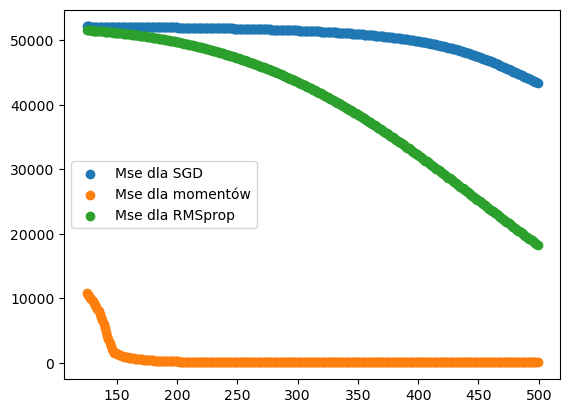

In [8]:
x,y = read('mio1/regression/square-large-test.csv')
compare(x,y,100,0.001,500,[1,6,6,1], times = 5)

In [9]:
x,y = read('mio1/regression/square-large-test.csv')
model1= NeuralNetwork([1,6,6,1])
print("Wczesne MSE:",model1.train(x,y,100,0.01,1000, method="Momentum")[-1])

Wczesne MSE: 1.063324813282401


MSE dla zbioru testowego: 1.2016912675345623


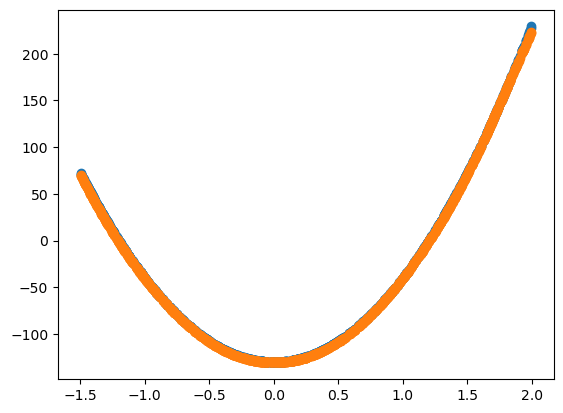

In [10]:
x,y = read('mio1/regression/square-large-training.csv')
plt.scatter(x,y)
plt.scatter(x,model1.fit(x))
print("MSE dla zbioru testowego:", model1.cost_fun(x,y))

Końcowe uśrednione mse dla SGD: 477.97031590514223
Końcowe uśrednione mse dla momentów: 95.67917090016337
Końcowe uśrednione mse dla RMSprop: 478.4569336767672


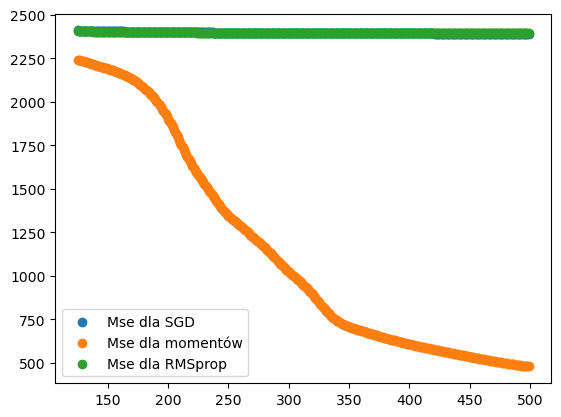

In [11]:
x,y = read('mio1/regression/steps-large-training.csv')
compare(x,y,100,0.001,500,[1,6,6,1], times=5)

Jak widać momenty są najlepsze trzeba tylko odpalić kilka razy by znaleźć dobry początek

In [12]:
x,y = read('mio1/regression/steps-large-training.csv')
model2 = NeuralNetwork([1,6,6,6,1])
print("Wczesne MSE:",model2.train(x,y,100,0.01,1000,method="Momentum")[-1])

Wczesne MSE: 10.57172536242074


In [ ]:
x,y = read('mio1/regression/steps-large-training.csv')
print("MSE na zbiorze traningowym",model2.train(x,y,100,0.01,3000,method="Momentum")[-1])
x,y = read('mio1\regression\steps-large-test.csv')
plt.scatter(x,y)
plt.scatter(x,model2.fit(x))
print("MSE na zbiorze testowym", model2.cost_fun(x,y))

In [ ]:
x,y = read('mio1/regression/multimodal-large-training.csv')
compare(x,y,100,0.001,500,[1,6,6,1], times=5)

In [ ]:
import time
start_time=time.time()
x,y = read('mio1\regression\multimodal-large-training.csv')
model3 = NeuralNetwork([1,8,1])
print("Wczesne MSE:",model3.train(x,y,100,0.01,1000,method="Momentum")[-1])
end_time=time.time()
end_time-start_time

In [ ]:
x,y = read('mio1/regression/multimodal-large-training.csv')
print("MSE na zbiorze treningowym",model3.train(x,y,100,0.01,3000,method="Momentum")[-1])
x,y = read('mio1/regression/multimodal-large-test.csv')
plt.scatter(x,y)
plt.scatter(x,model3.fit(x))
print("MSE na zbiorze testowym", model3.cost_fun(x,y))